In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os 
import sys
from datetime import datetime, timedelta
from modeling.utils import process_address
import warnings
import json 
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [ ]:
target = "price"
dense_features = ["LON", 
                "LAT", 
                "building_sqft", 
                "Lot Size", 
                "Year Built", 
                "Garage Number", 
                "Bedrooms", 
                "Baths", 
                "Maintenance Fee", 
                "Tax Rate", 
                "Recent Market Value", 
                "Recent Tax Value"]
cate = ["status", "Property Type", "County", "Private Pool", "Area Pool"]
time_col = ["date"]
cate_multi = ["Foundation_multiclass", "Garage Types_multiclass", 
            "Roof Type_multiclass", "Pool_feature_multiclass", "floor_type_multiclass", 
            "finance_option_multiclass", "Exterior Type_multiclass", "Style_multiclass"]

add_numerial_features = ["elementary_school_star", "middle_school_star", "high_school_star"]
add_cate_multi = ["school_org"] # ["school_names", "school_grades", "school_org"]

df = pd.read_pickle("data/property_structured.pkl")
df.head(2)

,address,LON,LAT,building_sqft,Lot Size,Year Built,Garage Number,Bedrooms,Baths,Maintenance Fee,Tax Rate,Recent Market Value,Recent Tax Value,status,Property Type,County,Private Pool,Area Pool,date,Foundation_multiclass,Garage Types_multiclass,Roof Type_multiclass,Pool_feature_multiclass,floor_type_multiclass,finance_option_multiclass,Exterior Type_multiclass,Style_multiclass,price
57,"4513 Refugio Dr, Plano, TX 75024",-96.782005,33.102204,3395.0,429.0,2023.0,2.0,4.0,3.5,65.083333,1.864,157533.0,157533.0,Under Contract - P,single family,Collin County,No,None,2023_11_05,[Slab],[Attached],[composition],None,"[carpet, ceramic tile, wood]",None,"[brick, rock/stone]",[traditional],789990.0
8,"1516 Bay Area Blvd P12, Houston, TX 77058",-95.114098,29.562197,684.0,31348.0,1977.0,NaN,1.0,1.0,272.000000,2.444,69024.0,47052.0,Under Contract - PS,townhouse/condo,Harris County,No,Yes,2023_11_05,[Slab],None,[composition],None,"[tile, vinyl]","[cash, conventional, fha, investor, va]","[brick, stucco]",[traditional],79900.0


In [6]:
raw_df = pd.read_pickle("data/contracted_houses_11052023_11062024.pkl")
raw_df.head(3)

,address,harlink,mp_features,agent,price,posted_days,status,zipcode,num_beds,num_bath,num_half_bath,building_sqft,has_loft,num_stories,num_parking_space,address_key,date,json_path,time_epoch,image_path,json_size,image_cnt
154,"1120 Skyline Dr, Wimberley, TX 78676",https://www.har.com//homedetail/1120-skyline-d...,"4 bedrooms 2,454 Sqft. ($326/Sqft.) 2 full & 1...",Jeff Coffman Coffman Real Estate,799900.0,118.0,Under Contract - OP,78676,4.0,0.0,0.0,2454.0,0.0,0.0,0.0,"1120 Skyline Dr, Wimberley, TX 78676",2024_01_19,/home/user/DataCenter/HAR_data/address_fullinf...,1718768786,/home/user/DataCenter/HAR_data/house_images/00...,156,0
397,"100 Cedar Hill St, Georgetown, TX 78628",https://www.har.com//homedetail/100-cedar-hill...,"4 bedrooms 2,813 Sqft. ($208/Sqft.) 2 full & 1...",Kim Whitlock Keller Williams Realty-RR WC,585000.0,96.0,Under Contract - P,78628,4.0,0.0,0.0,2813.0,0.0,0.0,0.0,"100 Cedar Hill St, Georgetown, TX 78628",2024_01_31,/home/user/DataCenter/HAR_data/address_fullinf...,1720237951,/home/user/DataCenter/HAR_data/house_images/00...,156,0
45,"14610 Becurtesy Ct, Cypress, TX 77429",https://www.har.com//homedetail/14610-becurtes...,"3 bedrooms 1,568 Sqft. ($188/Sqft.) 2 full bat...",Michael Glenny Roofline Realtors,294900.0,19.0,Under Contract - OP,77429,3.0,0.0,0.0,1568.0,0.0,0.0,0.0,"14610 Becurtesy Ct, Cypress, TX 77429",2024_02_20,/home/user/DataCenter/HAR_data/address_fullinf...,1722136513,/home/user/DataCenter/HAR_data/house_images/00...,156,0


In [ ]:
def read_json(json_path):
    with open(json_path) as f:
        return json.load(f)

sample_df = raw_df.sample(2000)
sample_df["content"] = sample_df["json_path"].apply(read_json)

In [105]:
def get_lon_lat(lon_str, lat_str):
    try:
        return float(lon_str), float(lat_str)
    except:
        return np.nan, np.nan

def parse_built_Sqft(content):
    try: 
        building_sqft = content["house_features"]["Building Sqft.:"]
    except:
        building_sqft = None
    if building_sqft is None:
        return np.nan
    built_sqft = str(building_sqft)
    try:
        built_sqft = built_sqft.split("(m²)")[0]
        built_sqft_, built_sqm_ = built_sqft[:-3], built_sqft[-3:]
        built_sqft_ = float(built_sqft_.replace(",", ""))
        built_sqm_ = float(built_sqm_)
        built_sqft_to_sqm = built_sqft_ * 0.092903 
        if abs(built_sqft_to_sqm - built_sqm_) / built_sqm_ < 0.05:
            return built_sqft_
        else:
            built_sqft_, built_sqm_ = built_sqft[:-2], built_sqft[-2:]
            built_sqft_ = float(built_sqft_.replace(",", ""))
            built_sqm_ = float(built_sqm_)
            built_sqft_to_sqm = built_sqft_ * 0.092903 
            if abs(built_sqft_to_sqm - built_sqm_) / built_sqm_ < 0.05:
                return built_sqft_
            else:
                return np.nan
    except Exception:
        return np.nan
    

def parse_ls1(ls1):
    ls1 = str(ls1)
    if ls1 == "nan":
        return np.nan
    if "Sqft." in ls1:
        ls_ = float(ls1.split("Sqft.")[1].replace("(m²)", "").replace(",", ""))
    if "Acres" in ls1:
        ls_ = float(ls1.split("Acres")[1].replace("(m²)", "").replace(",", ""))
    return ls_


def parse_lot_size(content):
    try: 
        lot_size = content["house_features"]["Lot Size:"]
    except:
        lot_size = "nan"
    lot_size = str(lot_size)
    if lot_size == "nan":
        return np.nan, ""
    ls1, ls2 = lot_size.split("/")
    lot_size_m2 = parse_ls1(ls1)
    return lot_size_m2, ls2


def parse_built_year(content):
    try: 
        built_year = str(content["house_features"]["Year Built:"])
    except:
        built_year = "nan"

    if built_year == "nan":
        return np.nan, np.nan
    year, source = built_year.split("/")
    year = int(year)
    if year == 20119:
        year = 2019
    return year, source.strip()


sample_df["LAT"], sample_df["LON"] = zip(*sample_df["content"].apply(lambda x: get_lon_lat(x["coords"][0], x["coords"][1])))
sample_df["building_sqft2"] = sample_df["content"].apply(lambda x: parse_built_Sqft(x))
sample_df["building_sqft"] = sample_df.apply(lambda x: x["building_sqft2"] if np.isnan(x["building_sqft2"]) is False else x["building_sqft"], axis=1)
sample_df["Lot Size"] = sample_df["content"].apply(lambda x: parse_lot_size(x)[0])
sample_df["Year Built"] = sample_df["content"].apply(lambda x: parse_built_year(x)[0])

<Axes: >

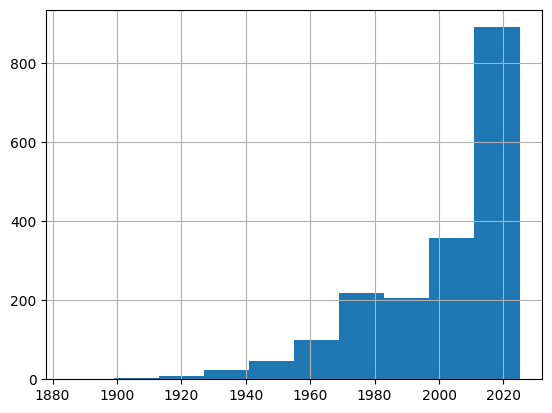

In [ ]:
sample_df["Year Built"].hist()

In [93]:
# 

In [ ]:
def parse_built_Sqft(content):
    try: 
        building_sqft = content["house_features"]["Building Sqft.:"]
    except:
        building_sqft = None
    if building_sqft is None:
        return np.nan
    built_sqft = str(building_sqft)
    try:
        built_sqft = built_sqft.split("(m²)")[0]
        built_sqft_, built_sqm_ = built_sqft[:-3], built_sqft[-3:]
        built_sqft_ = float(built_sqft_.replace(",", ""))
        built_sqm_ = float(built_sqm_)
        built_sqft_to_sqm = built_sqft_ * 0.092903 
        if abs(built_sqft_to_sqm - built_sqm_) / built_sqm_ < 0.05:
            return built_sqft_
        else:
            built_sqft_, built_sqm_ = built_sqft[:-2], built_sqft[-2:]
            built_sqft_ = float(built_sqft_.replace(",", ""))
            built_sqm_ = float(built_sqm_)
            built_sqft_to_sqm = built_sqft_ * 0.092903 
            if abs(built_sqft_to_sqm - built_sqm_) / built_sqm_ < 0.05:
                return built_sqft_
            else:
                return np.nan
    except Exception:
        return np.nan

In [ ]:
all_house_features = set()
for feat in sample_df["content"].apply(lambda x: x["house_neighborhood"]):
    all_house_features.update(feat.keys())
len(all_house_features)

28

In [44]:
all_house_features

{'Average Baths:',
 'Average Bedrooms:',
 'Average Lease/Square Ft.:',
 'Average Lease:',
 'Average List Price:',
 'Average Price/Square Ft.:',
 'Average Price:',
 'Average Rent:',
 'Average Square Ft.:',
 'Average Year Built:',
 'County / Zip Code:',
 'County:',
 'Home For Lease:',
 'Home For Sales:',
 'Homes for Lease:',
 'Homes for Sale:',
 'Market Area Name:',
 'Median Appraised Value / Square ft.:',
 'Median Appraised Value:',
 'Median Lot Square Ft.:',
 'Median Price / Square ft.:',
 'Median Square Ft.:',
 'Median Year Built:',
 'Name:',
 'Neighborhood Value Range:',
 'Price Range:',
 'Single Family Properties:',
 'Subdivision Name:'}